# Transcribe isoforms to get RNA sequence


In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import gffutils
import pybedtools
import re
import numpy as np

v19db_filename = '/projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotation.gtf.db'
v19db = gffutils.FeatureDB(v19db_filename)

folder = '/projects/ps-yeolab/obotvinnik/singlecell_pnms'

splicing_feature_data = pd.read_csv('{}/splicing_feature_data.csv'.format(folder), index_col=0)
splicing_feature_data.head()

/home/obotvinnik/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:784: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/obotvinnik/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())
/home/obotvinnik/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (11,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


,criteria,criteria_additional,criteria_full,ensembl_id,exon1,exon1_length,exon2,exon2_length,exon3,exon3_length,...,isoform2_protein_secondary_structure_turn,isoform1_aromaticity,isoform2_aromaticity,isoform1_iupred_score,isoform2_iupred_score,exon2_splice_site_3p_score,exon2_splice_site_3p_seq,exon2_splice_site_5p_score,exon2_splice_site_5p_seq,exon2_phastcons_placental_mammal
event_id,,,,,,,,,,,,,,,,,,,,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,best,appris_principal,"best,appris_principal",ENSG00000107521,exon:chr10:100190328-100190427:-,100,exon:chr10:100189548-100189646:-,99,exon:chr10:100189330-100189399:-,70,...,0.370787,NaN,0.056180,NaN,0.638962,7.77,CTCTCCCCTGCCCTGCACAGCCT,6.96,ACGGTGTGT,0.291112
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,only one,NaN,only one,ENSG00000107521,exon:chr10:100193697-100193848:-,152,exon:chr10:100190888-100191048:-,161,exon:chr10:100190328-100190427:-,100,...,NaN,NaN,NaN,NaN,NaN,9.08,TCCCTTCCTGCCCTGGCTAGGCC,7.96,TAGGTGAGC,0.803519
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,best,appris_principal,"best,appris_principal",ENSG00000107521,exon:chr10:100195392-100195529:-,138,exon:chr10:100195029-100195171:-,143,exon:chr10:100193697-100193848:-,152,...,NaN,NaN,NaN,NaN,NaN,7.92,TGGCCTGCCTGTGCCTGCAGTTT,6.05,GGAGTGAGT,0.839394
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,only one,NaN,only one,ENSG00000120053,exon:chr10:101165513-101165617:-,105,exon:chr10:101163481-101163631:-,151,exon:chr10:101163226-101163391:-,166,...,0.264286,NaN,0.135714,NaN,0.223048,10.79,CTCACTTTGCTTCCCCGCAGCAC,8.34,ACAGTGAGT,0.978780
exon:chr10:101419263-101419345:+@exon:chr10:101419619-101419721:+@exon:chr10:101421203-101421385:+,only one,NaN,only one,ENSG00000198018,exon:chr10:101419263-101419345:+,83,exon:chr10:101419619-101419721:+,103,exon:chr10:101421203-101421385:+,183,...,NaN,NaN,NaN,NaN,NaN,5.04,CTGAAATCAAATCTTTCTAGGCT,9.31,TAGGTAAGG,0.934804


In [2]:
splicing_feature_data.shape

(33693, 58)

In [3]:
figure_folder = '/home/obotvinnik/Dropbox/figures2/singlecell_pnms/isoform_rna_properties'
! mkdir $figure_folder

mkdir: cannot create directory `/home/obotvinnik/Dropbox/figures2/singlecell_pnms/isoform_rna_properties': File exists


## Transcribe isoforms

Get the RNA sequence form the DNA sequence

In [4]:
prefix = 'isoform_transcriptions'
transcribed_fasta = '{}/{}.fa'.format(folder, prefix)

In [ ]:
%%time

import itertools
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.Alphabet import generic_dna, generic_protein
import six

hg19_fasta = '/projects/ps-yeolab/genomes/hg19/gencode/v19/GRCh37.p13.genome.fa'

def overlap(x, y):
    return not ((x.start > y.stop) or (x.stop < y.start))

seqrecords = []


splice_type_isoform1_exons = {'SE': ('exon1', 'exon3'), 'MXE': ('exon1', 'exon3', 'exon4')}
splice_type_isoform2_exons = {'SE': ('exon1', 'exon2','exon3'), 'MXE': ('exon1', 'exon2', 'exon4')}

for i, (event_id, row) in enumerate(splicing_feature_data.iterrows()):
    if (i+1) % 1000 == 0:
        six.print_('\t Features completed', i+1)
        
    isoform1_exons = splice_type_isoform1_exons[row.splice_type]
    isoform2_exons = splice_type_isoform2_exons[row.splice_type]
    
    isoform_to_exons = {'isoform1': map(lambda x: v19db[row[x]], isoform1_exons),
                        'isoform2': map(lambda x: v19db[row[x]], isoform2_exons)}
        
    isoform_to_seq = {'isoform1': [], 'isoform2': []}

    reverse = isoform_to_exons['isoform1'][0].strand == '-'
    
    for isoform, exons in isoform_to_exons.items():
        if reverse:
            sequence = Seq(''.join(exon.sequence(hg19_fasta)[::-1] for exon in exons), generic_dna).complement()
        else:
            sequence = Seq(''.join(exon.sequence(hg19_fasta) for exon in exons), generic_dna)
        transcribed = sequence.transcribe()
        seqrecord = SeqRecord(transcribed, id='{0}|{1}'.format(event_id, isoform))
        seqrecords.append(seqrecord)


with open(transcribed_fasta, 'w') as f:
    SeqIO.write(seqrecords, f, 'fasta')

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000

In [9]:
! wc -l $transcribed_fasta

640663 /projects/ps-yeolab/obotvinnik/singlecell_pnms/isoform_transcriptions.fa


In [8]:
! head $transcribed_fasta

>exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-|isoform2 <unknown description>
CCACAGUGCCAGCUCCCUGCGCCCGGCCGACCUGCUUGCCCUCAUCCUCCUGGUUCAGGA
CCUCUACCCCAGCGAGAGCACAGCAGAGGACGACAUUCAGCCUUCCCCGCGGAGGGCCCG
GAGCAGCCAGAACAUCCCCGUGCAGCAGGCCUGGAGCCCUCACUCCACGGGCCCAACUGG
GGGGAGCUCUGCAGAGACGGAGACAGACAGCUUCUCCCUCCCUGAGGAGUACUUCACACC
AGCUCCUUCCCCUGGCGAUCAGAGCUCAG
>exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-|isoform1 <unknown description>
CCACAGUGCCAGCUCCCUGCGCCCGGCCGACCUGCUUGCCCUCAUCCUCCUGGUUCAGGA
CCUCUACCCCAGCGAGAGCACAGCAGAGGACGACAUUCAGGAGACAGACAGCUUCUCCCU
CCCUGAGGAGUACUUCACACCAGCUCCUUCCCCUGGCGAUCAGAGCUCAG


In [10]:
from Bio import SeqIO
from collections import defaultdict
from Bio import SeqUtils

transcripts = SeqIO.parse(transcribed_fasta, 'fasta')

data = []

for record in transcripts:
    event_id, isoform = record.id.split('|')
    
    gc123 = list(SeqUtils.GC123(record.seq))
    data.append([event_id, isoform] + gc123)
gc_content = pd.DataFrame(data, columns=['event_name', 'isoform', 'gc', 'gc_position1', 'gc_position2', 'gc_position3'])
gc_content
#     gc[isoform][event_id] = 

,event_name,isoform,gc,gc_position1,gc_position2,gc_position3
0,exon:chr10:100190328-100190427:-@exon:chr10:10...,isoform2,77.292576,89.610390,73.076923,68.918919
1,exon:chr10:100190328-100190427:-@exon:chr10:10...,isoform1,75.714286,87.500000,77.551020,60.465116
2,exon:chr10:100193697-100193848:-@exon:chr10:10...,isoform2,79.178886,73.333333,89.256198,73.913043
3,exon:chr10:100193697-100193848:-@exon:chr10:10...,isoform1,79.523810,88.311688,74.242424,74.626866
4,exon:chr10:100195392-100195529:-@exon:chr10:10...,isoform2,75.882353,75.206612,53.684211,93.548387
5,exon:chr10:100195392-100195529:-@exon:chr10:10...,isoform1,78.111588,81.927711,73.239437,78.481013
6,exon:chr10:101165513-101165617:-@exon:chr10:10...,isoform2,71.246006,70.642202,58.585859,83.809524
7,exon:chr10:101165513-101165617:-@exon:chr10:10...,isoform1,68.899522,62.318841,70.588235,73.611111
8,exon:chr10:101419263-101419345:+@exon:chr10:10...,isoform2,70.833333,66.666667,71.276596,75.000000
9,exon:chr10:101419263-101419345:+@exon:chr10:10...,isoform1,74.111675,74.242424,76.271186,72.222222


In [22]:
value_cols = ['gc', 'gc_position1', 'gc_position2', 'gc_position3']

In [23]:
dfs = []

for value_col in value_cols:
    df = gc_content.pivot(index='event_name', columns='isoform', values=value_col)
    df.columns = df.columns.map(lambda x: x + '_' + value_col)
    dfs.append(df)
gc_content_2d = pd.concat(dfs, axis=1)
gc_content_2d.head()

,isoform1_gc,isoform2_gc,isoform1_gc_position1,isoform2_gc_position1,isoform1_gc_position2,isoform2_gc_position2,isoform1_gc_position3,isoform2_gc_position3
event_name,,,,,,,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,75.714286,77.292576,87.500000,89.610390,77.551020,73.076923,60.465116,68.918919
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,79.523810,79.178886,88.311688,73.333333,74.242424,89.256198,74.626866,73.913043
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,78.111588,75.882353,81.927711,75.206612,73.239437,53.684211,78.481013,93.548387
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,68.899522,71.246006,62.318841,70.642202,70.588235,58.585859,73.611111,83.809524
exon:chr10:101419263-101419345:+@exon:chr10:101419619-101419721:+@exon:chr10:101421203-101421385:+,74.111675,70.833333,74.242424,66.666667,76.271186,71.276596,72.222222,75.000000


In [24]:
import seaborn as sns
%matplotlib inline

In [25]:
sns.set(style='ticks', context='talk')

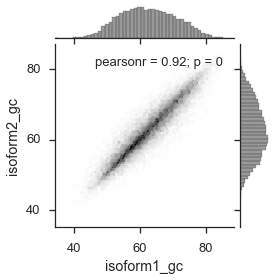

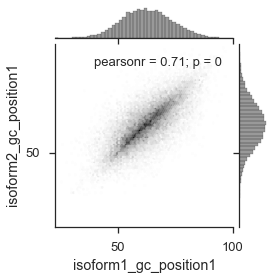

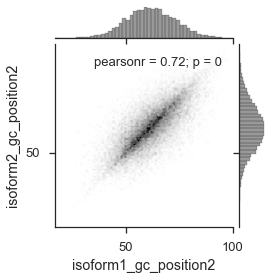

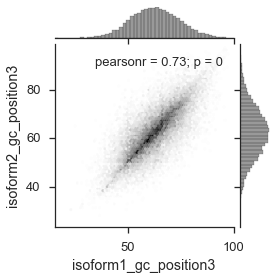

In [26]:
for value_col in value_cols:
    g = sns.jointplot('isoform1_{}'.format(value_col), 'isoform2_{}'.format(value_col), 
                  gc_content_2d, kind='hex', joint_kws=dict(mincnt=1), color='black', size=4)
    g.ax_joint.locator_params(nbins=4)
    g.savefig('{}/{}_jointplot.pdf'.format(figure_folder, value_col))

## Add to splicing feature data

In [18]:
gc_content.set_index('event_name')

,isoform,gc,gc_position1,gc_position2,gc_position3
event_name,,,,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,isoform2,77.292576,89.610390,73.076923,68.918919
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,isoform1,75.714286,87.500000,77.551020,60.465116
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,isoform2,79.178886,73.333333,89.256198,73.913043
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,isoform1,79.523810,88.311688,74.242424,74.626866
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,isoform2,75.882353,75.206612,53.684211,93.548387
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,isoform1,78.111588,81.927711,73.239437,78.481013
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,isoform2,71.246006,70.642202,58.585859,83.809524
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,isoform1,68.899522,62.318841,70.588235,73.611111
exon:chr10:101419263-101419345:+@exon:chr10:101419619-101419721:+@exon:chr10:101421203-101421385:+,isoform2,70.833333,66.666667,71.276596,75.000000


In [31]:
pd.options.display.max_columns = 50

In [32]:
join_cols = gc_content_2d.columns.difference(splicing_feature_data.columns)

if len(join_cols) > 0:
    splicing_feature_data = splicing_feature_data.join(gc_content_2d[join_cols])
splicing_feature_data.head()

,criteria,criteria_additional,criteria_full,ensembl_id,exon1,exon1_length,exon2,exon2_length,exon3,exon3_length,exon4,exon4_length,gencode_id,gene_name,intron_length,junction_exons12,junction_exons13,junction_exons23,junction_exons24,junction_exons34,strand,exon2_divisible_by_3,one_ensembl_id,splice_type,exon2_merkin2012_ancient,isoform1_gc,isoform1_gc_position1,isoform1_gc_position2,isoform1_gc_position3,isoform2_gc,isoform2_gc_position1,isoform2_gc_position2,isoform2_gc_position3
event_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,best,appris_principal,"best,appris_principal",ENSG00000107521,exon:chr10:100190328-100190427:-,100,exon:chr10:100189548-100189646:-,99,exon:chr10:100189330-100189399:-,70,NaN,NaN,ENSG00000107521.14,HPS1,928,chr10:100189647-100190327:-,chr10:100189400-100190327:-,chr10:100189400-100189547:-,NaN,NaN,-,True,ENSG00000107521,SE,False,75.714286,87.500000,77.551020,60.465116,77.292576,89.610390,73.076923,68.918919
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,only one,NaN,only one,ENSG00000107521,exon:chr10:100193697-100193848:-,152,exon:chr10:100190888-100191048:-,161,exon:chr10:100190328-100190427:-,100,NaN,NaN,ENSG00000107521.14,HPS1,3269,chr10:100191049-100193696:-,chr10:100190428-100193696:-,chr10:100190428-100190887:-,NaN,NaN,-,False,ENSG00000107521,SE,False,79.523810,88.311688,74.242424,74.626866,79.178886,73.333333,89.256198,73.913043
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,best,appris_principal,"best,appris_principal",ENSG00000107521,exon:chr10:100195392-100195529:-,138,exon:chr10:100195029-100195171:-,143,exon:chr10:100193697-100193848:-,152,NaN,NaN,ENSG00000107521.14,HPS1,1543,chr10:100195172-100195391:-,chr10:100193849-100195391:-,chr10:100193849-100195028:-,NaN,NaN,-,False,ENSG00000107521,SE,False,78.111588,81.927711,73.239437,78.481013,75.882353,75.206612,53.684211,93.548387
exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,only one,NaN,only one,ENSG00000120053,exon:chr10:101165513-101165617:-,105,exon:chr10:101163481-101163631:-,151,exon:chr10:101163226-101163391:-,166,NaN,NaN,ENSG00000120053.9,GOT1,2121,chr10:101163632-101165512:-,chr10:101163392-101165512:-,chr10:101163392-101163480:-,NaN,NaN,-,False,ENSG00000120053,SE,False,68.899522,62.318841,70.588235,73.611111,71.246006,70.642202,58.585859,83.809524
exon:chr10:101419263-101419345:+@exon:chr10:101419619-101419721:+@exon:chr10:101421203-101421385:+,only one,NaN,only one,ENSG00000198018,exon:chr10:101419263-101419345:+,83,exon:chr10:101419619-101419721:+,103,exon:chr10:101421203-101421385:+,183,NaN,NaN,ENSG00000198018.6,ENTPD7,1857,chr10:101419346-101419618:+,chr10:101419346-101421202:+,chr10:101419722-101421202:+,NaN,NaN,+,False,ENSG00000198018,SE,False,74.111675,74.242424,76.271186,72.222222,70.833333,66.666667,71.276596,75.000000


In [33]:
splicing_feature_data.to_csv('{}/splicing_feature_data.csv'.format(folder))

## Calculate miRNA hybridization

For RNA targets, James Broughton from the Pasquinelli lab recommends `RNAhybrid`, and to use just the first 17 nt of the mature miRNA. Wanted to use `fastx-trimmer` but it only takes DNA sequences  - `U`'s are illegal :(

In [34]:
from Bio import SeqIO
import sys
import os

result_seq = []
filename = '/projects/ps-yeolab/genomes/mirbase/release_21/human_mature.fa'
with open(filename) as infile:
    for seq in SeqIO.parse(infile, 'fasta'):
        result_seq.append(seq[:17])

trimmed_filename = '/projects/ps-yeolab/genomes/mirbase/release_21/human_mature_17bp.fa'
with open(trimmed_filename, 'w') as outfile:
    SeqIO.write(result_seq, outfile, 'fasta')

Submit a compute job to calculate microRNA hybridization.

In [35]:
from gscripts.qtools import Submitter

mirna_seqs = '/projects/ps-yeolab/genomes/mirbase/release_21/human_mature_17bp.fa'
rnahybrid_results = '/projects/ps-yeolab/obotvinnik/miso_helpers/hg19/se_exon2_RNAhybrid_mirbase_human_mature_17bp.txt'
command = 'RNAhybrid -e -27 -c -s 3utr_human -q {} -t {} > {}'.format(mirna_seqs, transcribed_fasta, rnahybrid_results)
sub = Submitter([command], 'RNAhybrid', walltime='168:00:00', write_and_submit=True)

job ID: 3598068


In [13]:
ls -lha RNAhybrid*

-rw-r--r-- 1 obotvinnik yeo-group 537 Oct 16 12:17 RNAhybrid.sh
-rw------- 1 obotvinnik yeo-group   0 Oct 16 12:17 RNAhybrid.sh.err
-rw------- 1 obotvinnik yeo-group  24 Oct 19 11:47 RNAhybrid.sh.out


In [15]:
!tail RNAhybrid*

==> RNAhybrid.sh <==
#PBS -V
#PBS -l walltime=168:00:00
#PBS -l nodes=1:ppn=1
#PBS -A yeo-group
#PBS -q home

# Go to the directory from which the script was called
cd $PBS_O_WORKDIR
RNAhybrid -e -27 -c -s 3utr_human -q /projects/ps-yeolab/genomes/mirbase/release_21/human_mature_17bp.fa -t /projects/ps-yeolab/obotvinnik/singlecell_pnms/skipped_exon_isoform_transcriptions.fa > /projects/ps-yeolab/obotvinnik/miso_helpers/hg19/se_exon2_RNAhybrid_mirbase_human_mature_17bp.txt


==> RNAhybrid.sh.err <==

==> RNAhybrid.sh.out <==
Nodes:        tscc-2-51


Reading the output takes a LONG time

In [10]:
%%time
import pandas as pd
from collections import Counter

rnahybrid = pd.read_csv('/projects/ps-yeolab/obotvinnik/miso_helpers/hg19/se_exon2_RNAhybrid_mirbase_human_mature_17bp.txt', 
                        sep=':', 
#                         index_col=[0, 1, 3], 
                        header=None,
                        names=['chrom', 'start-stop', 'exon_length', 'mirna', 'mirna_length',
                                                                 'minimum_free_energy', 'p_value', 'target_bound_start', 'mirna_unbound',
                                                                 'mirna_bound', 'exon_bound', 'exon_bound'])
rnahybrid = rnahybrid.ix[rnahybrid.minimum_free_energy < -28]
grouped = rnahybrid.groupby(['chrom', 'start-stop'])
chrom_startstop_mirna = grouped.mirna.apply(lambda x: ','.join('{}[{}]'.format(k, v) for k,v in Counter(x).items()))
chrom_startstop_mirna.head()

CPU times: user 13.6 s, sys: 991 ms, total: 14.6 s
Wall time: 15.3 s


In [16]:
! head /projects/ps-yeolab/obotvinnik/miso_helpers/hg19/se_exon2_RNAhybrid_mirbase_human_mature_17bp.txt

target too long: exon:chr10:102114184-102114389:+@exon:chr10:102116289-102116521:+@exon:chr10:102120491-102124591:+|isoform2
target too long: exon:chr10:102114184-102114389:+@exon:chr10:102116289-102116521:+@exon:chr10:102120491-102124591:+|isoform1
target too long: exon:chr10:103298050-103298128:+@exon:chr10:103310456-103310648:+@exon:chr10:103312912-103317078:+|isoform2
target too long: exon:chr10:103298050-103298128:+@exon:chr10:103310456-103310648:+@exon:chr10:103312912-103317078:+|isoform1
exon:chr10:104140263-104140443:+@exon:chr10:104140884-104141012:+@exon:chr10:104141813-104142656:+|isoform2:1154:hsa-let-7a-5p:17:-27.0:0.102090:837:C                C: UGCAGCCU CUGCCUC : AUGUUGGA GAUGGAG :         U       U
exon:chr10:104140263-104140443:+@exon:chr10:104140884-104141012:+@exon:chr10:104141813-104142656:+|isoform1:1025:hsa-let-7a-5p:17:-27.0:0.086480:708:C                C: UGCAGCCU CUGCCUC : AUGUUGGA GAUGGAG :         U       U
target too long: exon:chr10:106037652-106037874:+@